In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', False)

import random

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  

import xgboost as xgb

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

In [3]:
data = pd.read_csv('/kaggle/input/pcos-diagnosis-dataset/pcos_dataset.csv')

In [4]:
data.head()

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1000 non-null   int64  
 1   BMI                        1000 non-null   float64
 2   Menstrual_Irregularity     1000 non-null   int64  
 3   Testosterone_Level(ng/dL)  1000 non-null   float64
 4   Antral_Follicle_Count      1000 non-null   int64  
 5   PCOS_Diagnosis             1000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [6]:
for i in data.columns:
    print(f'{i} min-max value -> {min(data[i])}-{max(data[i])}')

Age min-max value -> 18-45
BMI min-max value -> 18.1-35.0
Menstrual_Irregularity min-max value -> 0-1
Testosterone_Level(ng/dL) min-max value -> 20.0-99.8
Antral_Follicle_Count min-max value -> 5-29
PCOS_Diagnosis min-max value -> 0-1


In [7]:
data['Menstrual_Irregularity'] = data['Menstrual_Irregularity'].astype('category')
data['PCOS_Diagnosis'] = data['PCOS_Diagnosis'].astype('category')

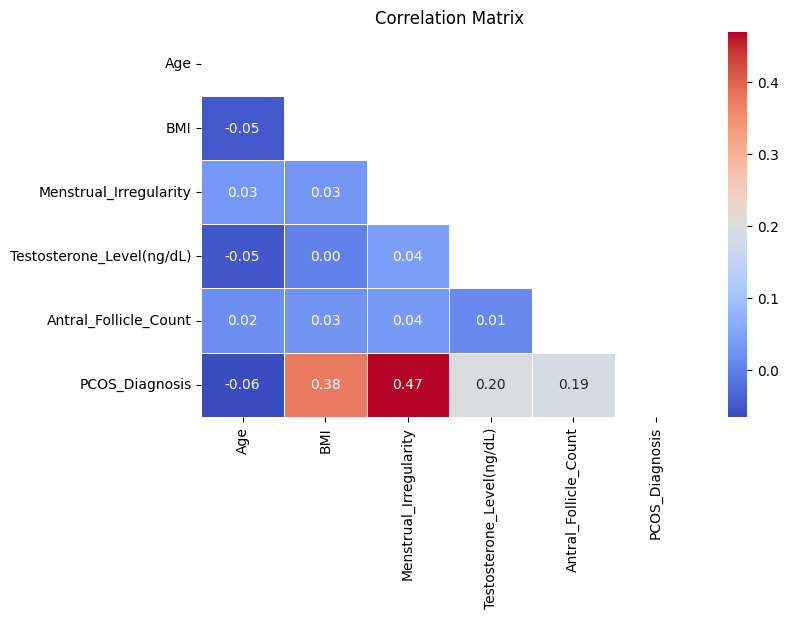

In [8]:
dt_corr = data.corr(method='spearman')
mask = np.triu(np.ones_like(dt_corr, dtype=bool))
plt.figure(figsize=(8, 5)) 
sns.heatmap(data.corr(method='spearman'), mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [9]:
def visualize_data(df, dataset_name="PCOS"):
    numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    if numeric_cols:
        for col in numeric_cols:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            sns.histplot(df[col], bins=30, kde=True, ax=axes[0],  color='blue')
            axes[0].set_title(f'{col} Histogram ({dataset_name})')
            
            sns.boxplot(x=df[col], ax=axes[1],  color='blue')
            axes[1].set_title(f'{col} Boxplot ({dataset_name})')
            
            plt.tight_layout()
            plt.show()
    else:
        print(f"No numeric columns in {dataset_name}!")

    if categorical_cols:
        for col in categorical_cols:
            fig, ax = plt.subplots(figsize=(6, 6))
            
            df[col].value_counts().plot.pie(
                autopct='%1.1f%%', startangle=90,  color='blue', ax=ax
            )
            ax.set_ylabel('')
            ax.set_title(f'Pie Chart of {col} ({dataset_name})')
            
            plt.show()
    else:
        print(f"No categorical columns in {dataset_name}!")

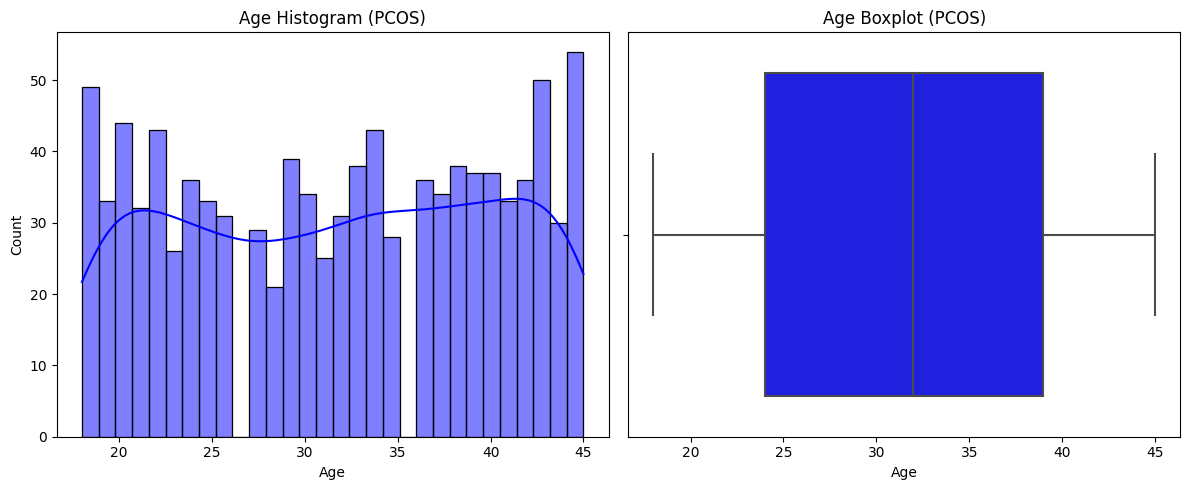

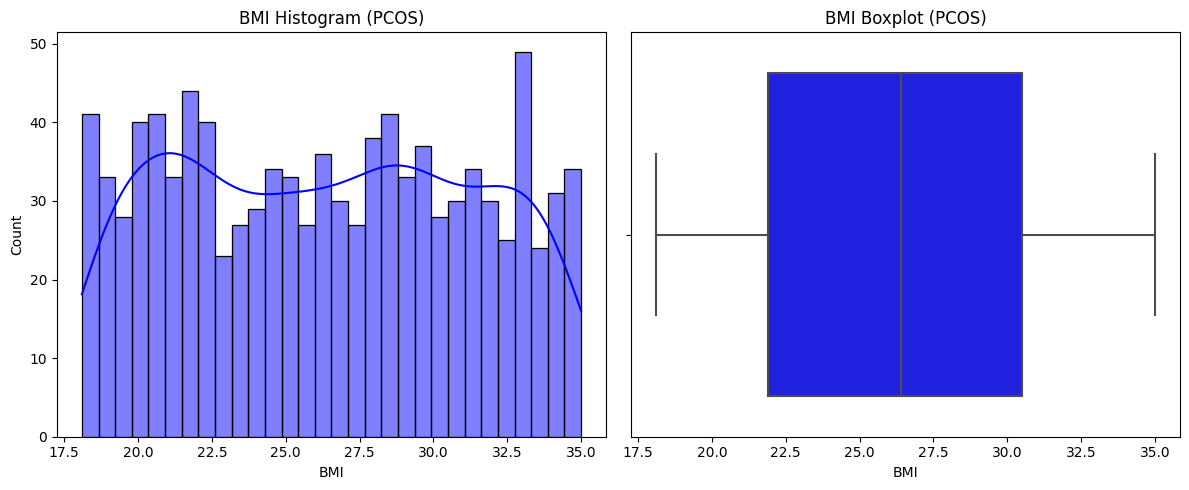

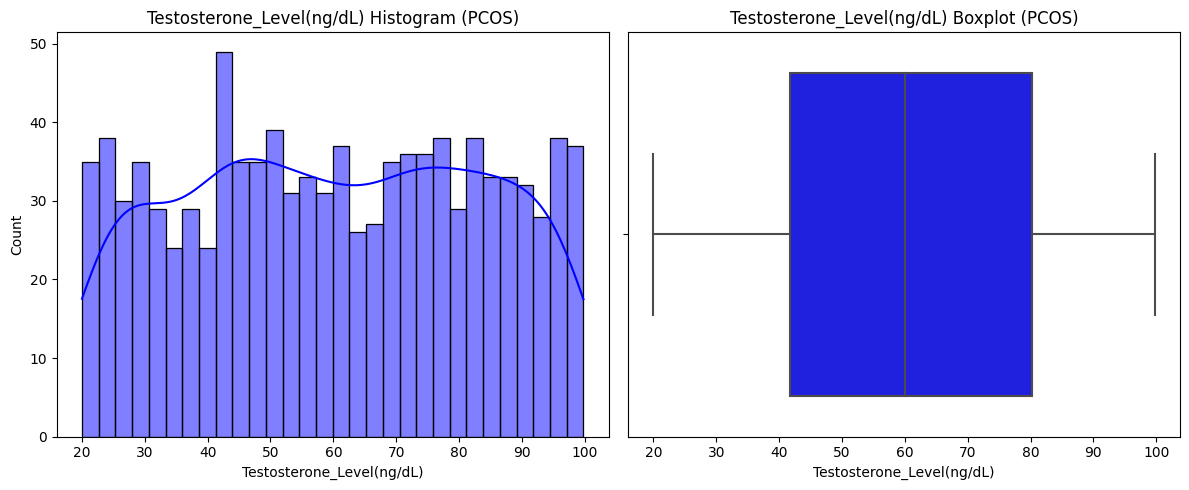

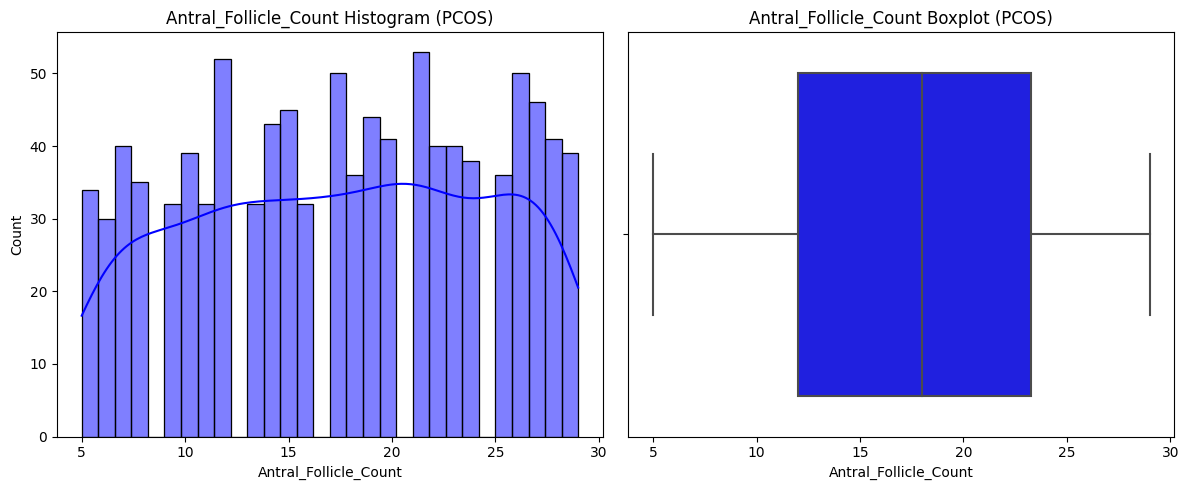

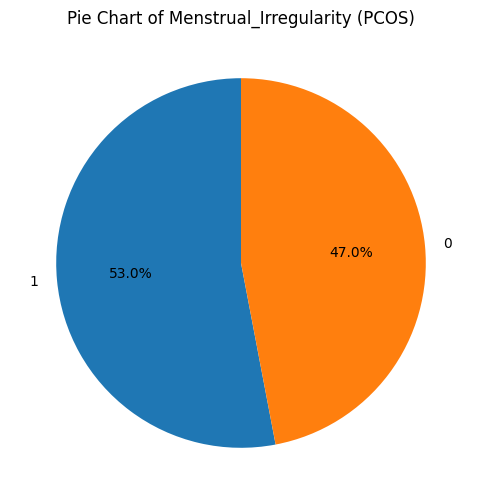

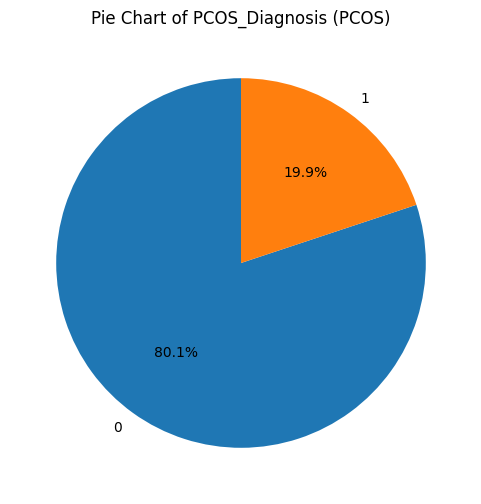

In [10]:
visualize_data(data)

In [11]:
class XGBoost_Model_Optimizer:
    def __init__(self, n_trials, seed=42, use_gpu=False):
        self.n_trials = n_trials
        self.best_model = None
        self.study = None
        self.seed = seed
        self.use_gpu = use_gpu
        self.cm = None
        self.model_path = 'xgb_best_model.json'
        self.history = []  
        np.random.seed(seed)

    def objective_xgb(self, trial, X_train, X_test, y_train, y_test):
        param = {
            'objective': 'binary:logistic',  
            'eval_metric': 'logloss',  
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'n_jobs': -1, 
            'random_state': self.seed
        }

        if self.use_gpu:
            param['tree_method'] = 'gpu_hist' 
        else:
            param['tree_method'] = 'hist'  

        model = xgb.XGBClassifier(**param)
        model.fit(X_train, y_train, verbose=False)

        preds = model.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        self.history.append(accuracy)
        return 1 - accuracy  

    def train_xgb(self, X_train, X_test, y_train, y_test):
        print("📌 Optimization process started...")
        self.study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=self.seed))
        self.study.optimize(lambda trial: self.objective_xgb(trial, X_train, X_test, y_train, y_test), n_trials=self.n_trials)

        best_params = self.study.best_params
        print(f'🏆 Best parameters found: {best_params}')

        self.best_model = xgb.XGBClassifier(**best_params)
        self.best_model.fit(X_train, y_train, verbose=False)

        best_accuracy = max(self.history) 
        self.best_model.save_model(self.model_path)
        print(f'\n💾 Best model saved at -> {self.model_path}')
        print(f'✅ Best Accuracy: {best_accuracy:.4f}')

        self.print_metrics(X_test, y_test)

    def print_metrics(self, X_test, y_test):
        preds = self.best_model.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        self.cm = confusion_matrix(y_test, preds)

        print(f"\n📝 Model Evaluation Metrics:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")
        print(f"  Confusion Matrix:\n{self.cm}")

    def plt_learning_curve_xgb(self):
        if not self.history:
            print('❌ You need to train a model first!')
            return
        plt.plot(self.history, marker='x', linestyle='-')
        plt.xlabel('Trials')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Learning Curve')
        plt.show()
        
    def plt_cm(self):
        if self.cm is None:
            print('❌ You need to train a model first!')
        else:
            plt.figure(figsize=(6,5))
            sns.heatmap(self.cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
            plt.xlabel("Predicted Labels")
            plt.ylabel("True Labels")
            plt.title("Confusion Matrix")
            plt.show()
        
    def predict_xgb(self, p_data):
        try: 
            pred_model = xgb.XGBClassifier()
            pred_model.load_model(self.model_path)
            return pred_model.predict(p_data)    
        except FileNotFoundError:
            print(f'🚨 Error: Model file "{self.model_path}" not found. You need to train a model first!')
        except Exception as e:
            print(f'⚠️ Unexpected error: {e}')


In [12]:
df_train = data.drop(columns=['PCOS_Diagnosis'])
encoder = LabelEncoder()
df_train['Menstrual_Irregularity'] = encoder.fit_transform(df_train['Menstrual_Irregularity'])

y = data['PCOS_Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=42)

📌 Optimization process started...
🏆 Best parameters found: {'learning_rate': 0.026619018884890575, 'n_estimators': 222, 'max_depth': 3, 'subsample': 0.8736932106048627, 'colsample_bytree': 0.7760609974958406, 'gamma': 0.12203823484477883, 'min_child_weight': 5}

💾 Best model saved at -> xgb_best_model.json
✅ Best Accuracy: 0.9950

📝 Model Evaluation Metrics:
  Accuracy: 0.9900
  Precision: 1.0000
  Recall: 0.9487
  F1-score: 0.9737
  Confusion Matrix:
[[161   0]
 [  2  37]]


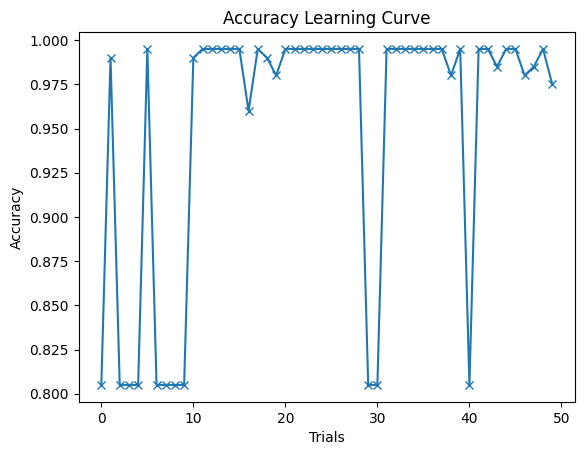

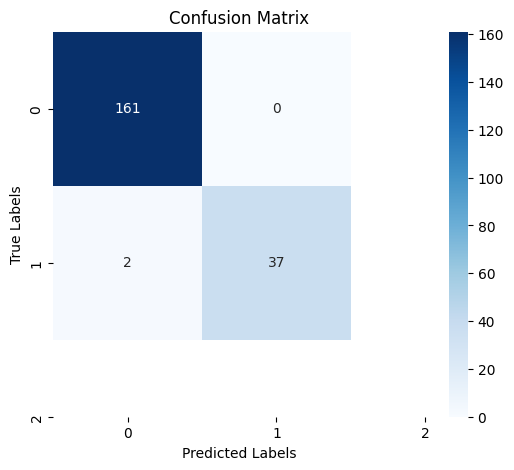

In [13]:
xgb_model = XGBoost_Model_Optimizer(n_trials=50)
xgb_model.train_xgb(X_train, X_test, y_train, y_test)
xgb_model.plt_learning_curve_xgb()
xgb_model.plt_cm()